# Topic modeling 
## US Presidents' State of the Union Addresses and Messages
Data: http://www.presidency.ucsb.edu/sou.php
Inspiration: https://www.exaptive.com/blog/topic-modeling-the-state-of-the-union

In [1]:
# See Scrape notebook for the scraping. Import the messages stored in the documents list
import pickle
pkl_file = open('documents_raw.pkl', 'rb')
documents_raw = pickle.load(pkl_file)
documents_raw[-1][0:3000]

"Thank you very much. Mr. Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States, and citizens of America: Tonight, as we mark the conclusion of our celebration of Black History Month, we are reminded of our Nation's path towards civil rights and the work that still remains to be done. Recent threats targeting Jewish community centers and vandalism of Jewish cemeteries, as well as last week's shooting in Kansas City, remind us that while we may be a nation divided on policies, we are a country that stands united in condemning hate and evil in all of its very ugly forms.  Each American generation passes the torch of truth, liberty, and justice in an unbroken chain, all the way down to the present. That torch is now in our hands, and we will use it to light up the world. I am here tonight to deliver a message of unity and strength, and it is a message deeply delivered from my heart. A new chapter of American greatness is now beginning. A new national pride 

### Clean the messages in the documents list

In [2]:
#Create documents list with tokenized text
# Tokenize
from nltk.corpus import stopwords 
import string
import re
stop = set(stopwords.words('english')) #NB a set is more efficient than a list
exclude = set(string.punctuation) 
#from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
#pstemmer = PorterStemmer()
def clean_text(doc, skipWords=[]):
    for w in skipWords:
        doc = doc.replace(w,'')
    #Remove non unicode (accents etc). Remove words that starts with non-letter and ends with non-letter. 
    #"1st" "a2" "1a3" safe, "1" "123" esta' " not
    letters_only = re.sub(r'\W|\b\w*\d\b', ' ', doc.lower())    
    #Split into individual words and remove stop words
    #This can be done in TfidfVectorizer/CountVectorizer but ok..
    stop_free = " ".join([i for i in letters_only.split() if i not in stop])
    #Remove punctuations should not be needed after letters_only but who knows
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #Stemming/Lemmatizing
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
documents = [clean_text(doc, skipWords=['[Laughter]','[Applause]']) for doc in documents_raw]

### Apply [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to documents

Use CountVectorizer and TF-IDF (term frequency-interdocument frequency) to represent texts as vectors. 

[CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) creates a vector of word counts from each text (a single speech). The text is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity ([Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)). 

[TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is similar but also applies normalization by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. TF-IDF reflects how important a word is to a document in a collection or corpus ([Wikipedia](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)).

CountVectorizer is used for LDA, TfidfVectorizer for NMF
![alt text](http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402 "Bag of words")



In [4]:
# Learn the vocabulary dictionary and return term-document matrix.
from sklearn.feature_extraction.text import CountVectorizer
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(analyzer='word', stop_words='english', #token_pattern = r'\b[a-zA-Z]{3,}\b',#strip_accents='ascii', tokenizer=lemma.lemmatize, lowercase=True, 
                        ngram_range=(1,2), max_df=0.5, min_df=5, max_features=1000)
#Fit Transform - Learn the vocabulary dictionary and return term-document matrix
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names() #maps feature indices -> feature name

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), #strip_accents='ascii', tokenizer=lemma.lemmatize, lowercase=True, 
                        stop_words='english', max_df=0.6, min_df=5, max_features=3000)
#Fit Transform - Learn the vocabulary dictionary and return term-document matrix
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

### Fit [LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
I am using 2-grams (i.e. features composed of two words). 4 topics can be discerned using a quite low cutoff for the words appearing in more than 50% of the documets (max_df=0.5). 

I played with the parameters and I often got "bad" models, i.e. very 'small' a 'degenerate' topic with low or zero token (i.e. word) presence in the corpus. 
This happens when increasing the number of features to 2000 or more, adding a 5th topic, increasing max_df, etc. The parameter min_df removes words present in less than 5 documents of the corpus. a value of min_df=5 seems fine, it shows more interesting words such as 'oil'.

The fit with 3-grams as in the site above is worse. The text of the original messages include words such as [Laughter] and [Applause]. The analysis in the link above seems to have to include these words (in fact one of the main features is "laughter"). Interestingly, keeping these spurious words in the corpus makes it easier to fit 4 topics. 

<!-- max_features is important. None is bad (one blob). 2000 better than 1000. 3000 2 blobs
#3000 and max_df=0.6 instead of 0.9 I get 2.5 blobs. min_df=0.15 instead of 0.05 I get 4 blobs. 3 nice topics. it is no_topics = 4, max_df=0.6, min_df=0.15, max_features=2000)
#I try max_df=0.5, min_df=10, max_features=2000 but no
#Cannot get 5th topic

#LDA
#max_df: 0.5. with 0.9 means only 3 real topics. 0.6 is still quite high and 4th topic is small
#min_df: 5 is ok, low you get interesting words such as oil
#max_features: 1500. 2000/3000 you start losing 4th, most of all if high max_df. rising min_df does not help. 500 loses 4th
#?? 5/6 topics with max_df=0.5, min_df=5, max_features=1500. topics slightly small/similar. cannot rise max_df to 0.6
--->

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
no_topics = 4
# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0, n_jobs=2)
lda.fit(tf)
# Display the terms in the topics
#tf_vectorizer.get_feature_names(): map feature indices -> feature name
#lda.components_[i,j] (topic word distribution): "weights" of terms j in topic i
def display_topics(model, feature_names, no_top_words):
    for ind, topic in enumerate(model.components_):
        print("Topic %d:" % (ind))
        print(" ".join([feature_names[i]+' -'
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
print
print("LDA:")
display_topics(lda, tf_feature_names, no_top_words = 10)
#Plot with pyLDAvis - see http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb
import pyLDAvis.sklearn, pyLDAvis
pyLDAvis.enable_notebook();
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/home/amarin/.local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LDA:
Topic 0:
expenditure - fiscal year - million dollar - shall - veteran - estimated - recommended - management - adequate - appropriation -
Topic 1:
terrorist - iraq - company - republican - class - medicare - bipartisan - got - big - kid -
Topic 2:
oil - rural - management - state local - established - transportation - addition - funding - regulatory - regulation -
Topic 3:
shall - communist - free world - united nation - vietnam - free nation - recommend - aggression - expenditure - session -


/home/amarin/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.031835 -0.037208       1        1  40.838610
1     -0.079407 -0.001358       2        1  30.352172
3      0.010105  0.013461       3        1  17.499164
0      0.037467  0.025106       4        1  11.310054, topic_info=     Category        Freq                Term       Total  loglift  logprob
term                                                                       
323   Default  181.000000         expenditure  181.000000  30.0000  30.0000
355   Default  162.000000         fiscal year  162.000000  29.0000  29.0000
795   Default  236.000000               shall  236.000000  28.0000  28.0000
556   Default   90.000000      million dollar   90.000000  27.0000  27.0000
150   Default  137.000000           communist  137.000000  26.0000  26.0000
882   Default  140.000000           terrorist  140.000000  25.0000  25.0000
311   Default   60.000000           estimated   60.000000  24.0000  24.0000
932   Default  122.000000       united nation  122.000000  23.0000  23.0000
375   Default   97.000000          free world   97.000000  22.0000  22.0000
721   Default   83.000000         recommended   83.000000  21.0000  21.0000
528   Default  172.000000          management  172.000000  20.0000  20.0000
20    Default  100.000000            adequate  100.000000  19.0000  19.0000
720   Default  118.000000           recommend  118.000000  18.0000  18.0000
471   Default  127.000000                iraq  127.000000  17.0000  17.0000
943   Default  153.000000             veteran  153.000000  16.0000  16.0000
374   Default   81.000000         free nation   81.000000  15.0000  15.0000
56    Default   64.000000       appropriation   64.000000  14.0000  14.0000
14    Default  136.000000            activity  136.000000  13.0000  13.0000
40    Default   93.000000         agriculture   93.000000  12.0000  12.0000
947   Default  102.000000             vietnam  102.000000  11.0000  11.0000
152   Default  119.000000             company  119.000000  10.0000  10.0000
35    Default  105.000000          aggression  105.000000   9.0000   9.0000
322   Default   57.000000            expected   57.000000   8.0000   8.0000
713   Default   39.000000             receipt   39.000000   7.0000   7.0000
75    Default   53.000000       authorization   53.000000   6.0000   6.0000
310   Default   44.000000            estimate   44.000000   5.0000   5.0000
745   Default   96.000000          republican   96.000000   4.0000   4.0000
127   Default   93.000000               class   93.000000   3.0000   3.0000
865   Default  100.000000             surplus  100.000000   2.0000   2.0000
1     Default   79.000000        21st century   79.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
181    Topic4   15.451519            contract   39.871225   1.2315  -5.9947
574    Topic4   14.510653    national defense   38.978859   1.1913  -6.0575
587    Topic4   14.274938                 net   40.006812   1.1489  -6.0739
632    Topic4   18.816458           peacetime   54.703790   1.1123  -5.7977
828    Topic4   10.432629     standard living   32.210671   1.0521  -6.3875
483    Topic4   19.272580                june   61.153257   1.0248  -5.7737
420    Topic4   10.975591          high level   34.978365   1.0204  -6.3367
582    Topic4   12.406471                navy   39.567015   1.0197  -6.2142
21     Topic4   14.839997          adjustment   47.478118   1.0165  -6.0351
600    Topic4    9.339469             old age   30.393600   0.9995  -6.4982
665    Topic4    9.611708  private enterprise   31.504016   0.9923  -6.4694
20     Topic4   29.558135            adequate  100.140328   0.9593  -5.3460
76     Topic4   10.681069          authorized   37.528656   0.9228  -6.3639
40     Topic4   26.276761         agriculture   93.080232   0.9147  -5.4637
787    Topic4   15.703530           september   56.511759   0

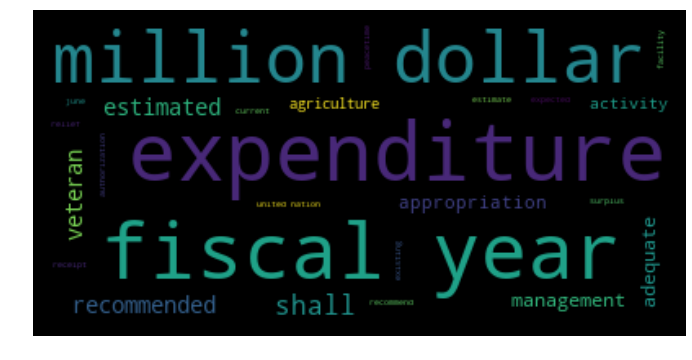

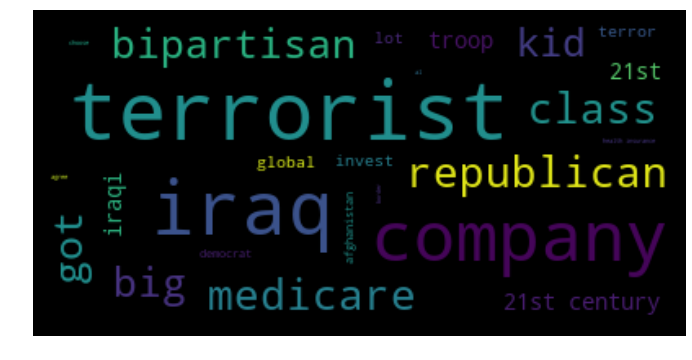

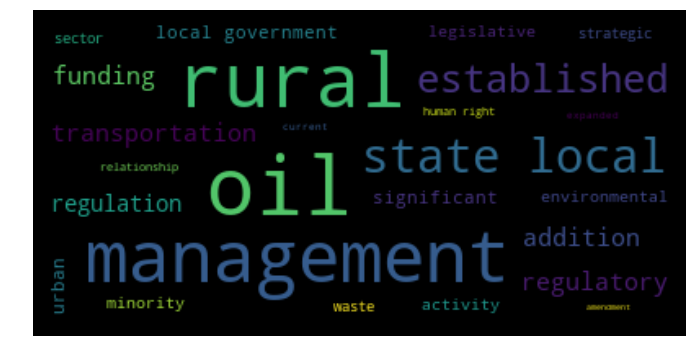

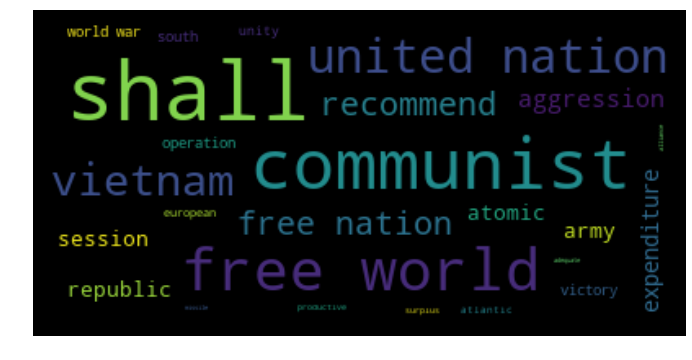

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, ImageColorGenerator

def plot_wordcloud(components,feature_names,numbest = 25):
    for t in range(len(components)):
        best_terms = dict([(feature_names[i],components[t,i]) for i in components[t].argsort()[:-numbest-1:-1].tolist()])
        # Generate a word cloud image
        wordcloud = WordCloud(width=400, height=200, margin=20, background_color='black', max_font_size=50) #random_state=i, 
        wordcloud.generate_from_frequencies(best_terms)
        # Display the generated image:
        # the matplotlib way:
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(12, 6))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation='bilinear')

plot_wordcloud(lda.components_,tf_feature_names,25)

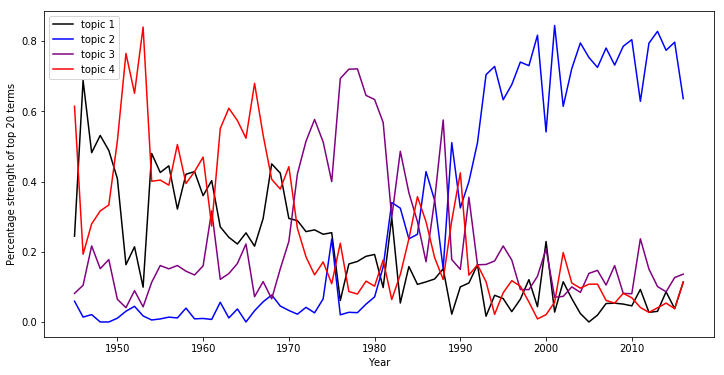

In [13]:
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline
def plotTraces(model, feature_names, numbest = 20):
    stacked = feature_names[:,model.components_.argsort()[0,:-numbest-1:-1]].transpose().sum(axis=0)
    for t in range(1,4):
        stacked = np.vstack((stacked, feature_names[:,lda.components_.argsort()[t,:-numbest-1:-1]].transpose().sum(axis=0)))
    stacked = normalize(stacked,norm='l1',axis=0)

    fig = plt.figure(figsize=(12, 6))
    scat0=plt.plot(range(1945,2017), stacked[0,:], color='black', label='topic 1')
    scat1=plt.plot(range(1945,2017), stacked[1,:], color='blue', label='topic 2')
    scat2=plt.plot(range(1945,2017), stacked[2,:], color='purple', label='topic 3')
    scat3=plt.plot(range(1945,2017), stacked[3,:], color='red', label='topic 4')
    plt.xlabel("Year")
    plt.ylabel("Percentage strenght of top "+str(numbest)+" terms")
    plt.legend(loc="best")
    plt.show();     #NB ; to suppress output
    
    return stacked
    

plotTraces(lda, tf, 20);

### Fit [NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

It is possible to run NMF with a higher number of topics than LDA, higher max_features. 
A high max_df causes some topics to overlap, which makes sense. Even if it is possible to run NMF with up to 8 topics (paramenters: max_df=0.55, min_df=5, max_features=5000), the success of the fit becomes very sensitive on the parameters. 

4 topics prrovide a more "stable" fit: the topics are well separated

In [14]:
#NMF max_df=0.5, min_df=5, max_features=1500  ; random_state=1, alpha=.1, l1_ratio=.5     no_topics = 6   
#more topics. full topics but clustered
#lower min_df clusters more
#max_df=0.55, min_df=5, max_features=4000or5000  ; 4 topics is well separated but 5th is subset of first. 
#After than you can go up to 8 topics, except 1 and 3 they are distinct but not very big
#4 topic is most stable: you cannot put max_df=0.65 or change much parameters (error about onfs or NaNs)
#Maybe more overlap when max_df is higher, it makes sense
from sklearn.decomposition import NMF
# NMF is able to use tf-idf
no_topics = 4
# Run NMF
nmf = NMF(n_components=no_topics, random_state=0, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
import pyLDAvis.sklearn, pyLDAvis#See http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb
pyLDAvis.enable_notebook();
pyLDAvis.sklearn.prepare(nmf, tfidf, tfidf_vectorizer)

/home/amarin/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/amarin/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/amarin/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/amarin/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.180190 -0.126998       1        1  44.005450
1      0.009617 -0.216532       2        1  41.060157
3     -0.219301  0.254007       3        1   8.707603
2      0.389873  0.089523       4        1   6.226789, topic_info=     Category      Freq                     Term     Total  loglift  logprob
term                                                                        
1424  Default  6.000000                     iraq  6.000000  30.0000  30.0000
2684  Default  6.000000                terrorist  6.000000  29.0000  29.0000
1425  Default  5.000000                    iraqi  5.000000  28.0000  28.0000
2682  Default  3.000000                   terror  3.000000  27.0000  27.0000
100   Default  3.000000                       al  3.000000  26.0000  26.0000
2135  Default  2.000000                    qaida  2.000000  25.0000  25.0000
101   Default  2.000000                 al qaida  2.000000  24.0000  24.0000
881   Default  2.000000                    enemy  2.000000  23.0000  23.0000
2219  Default  2.000000                   regime  2.000000  22.0000  22.0000
75    Default  2.000000              afghanistan  2.000000  21.0000  21.0000
1837  Default  3.000000                      oil  3.000000  20.0000  20.0000
2348  Default  1.000000                   saddam  1.000000  19.0000  19.0000
2429  Default  6.000000                    shall  6.000000  18.0000  18.0000
2349  Default  1.000000           saddam hussein  1.000000  17.0000  17.0000
1308  Default  1.000000                  hussein  1.000000  16.0000  16.0000
2094  Default  2.000000                 proposed  2.000000  15.0000  15.0000
2224  Default  1.000000               regulatory  1.000000  14.0000  14.0000
2339  Default  2.000000                    rural  2.000000  13.0000  13.0000
2757  Default  1.000000                    troop  1.000000  12.0000  12.0000
861   Default  2.000000               employment  2.000000  11.0000  11.0000
2223  Default  1.000000               regulation  1.000000  10.0000  10.0000
79    Default  2.000000                   agency  2.000000   9.0000   9.0000
1131  Default  2.000000                  funding  2.000000   8.0000   8.0000
789   Default  3.000000                     drug  3.000000   7.0000   7.0000
912   Default  1.000000            environmental  1.000000   6.0000   6.0000
0     Default  1.000000                     11th  1.000000   5.0000   5.0000
2870  Default  1.000000               war terror  1.000000   4.0000   4.0000
1598  Default  2.000000               management  2.000000   3.0000   3.0000
296   Default  1.000000                   border  1.000000   2.0000   2.0000
421   Default  1.000000                coalition  1.000000   1.0000   1.0000
...       ...       ...                      ...       ...      ...      ...
1890   Topic4  0.778514              palestinian  0.867348   2.6683  -4.8085
2219   Topic4  1.959163                   regime  2.190318   2.6648  -3.8857
1424   Topic4  5.582492                     iraq  6.412483   2.6377  -2.8385
1502   Topic4  0.615398                  lebanon  0.713200   2.6288  -5.0437
2682   Topic4  2.746190                   terror  3.187637   2.6272  -3.5480
703    Topic4  0.149961                destroyed  0.178312   2.6031  -6.4556
2406   Topic4  0.884959                september  1.052791   2.6027  -4.6804
1718   Topic4  0.601782                   murder  0.719550   2.5976  -5.0660
800    Topic4  0.667531                  earmark  0.800441   2.5947  -4.9623
2887   Topic4  0.871602              weapon mass  1.045693   2.5942  -4.6956
2684   Topic4  5.289904                terrorist  6.584686   2.5574  -2.8924
1614   Topic4  0.597103         mass destruction  0.750877   2.5472  -5.0738
2888   Topic4  0.623818  weapon mass destruction  0.785491   2.5459  -5.0301
1903   Topic4  0.101397                passenger  0.128163   2.5421  -6.8469
100    Topic4 

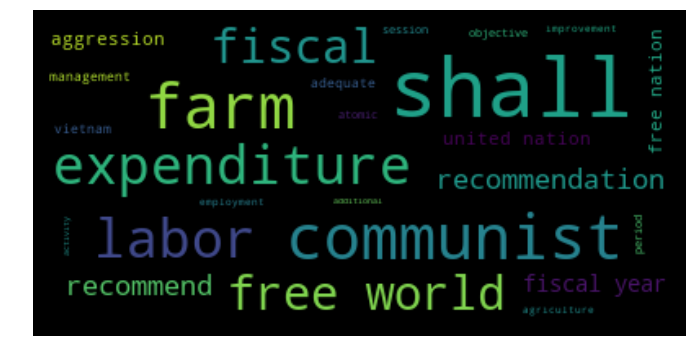

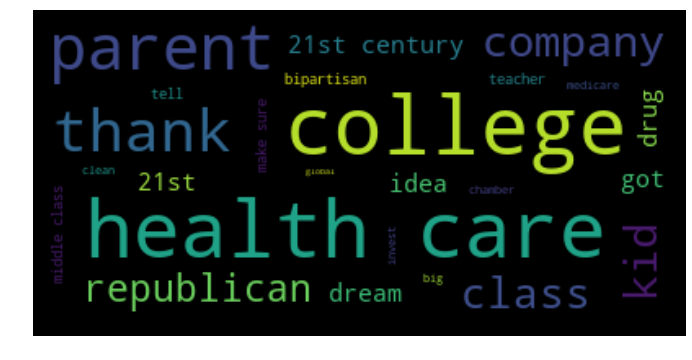

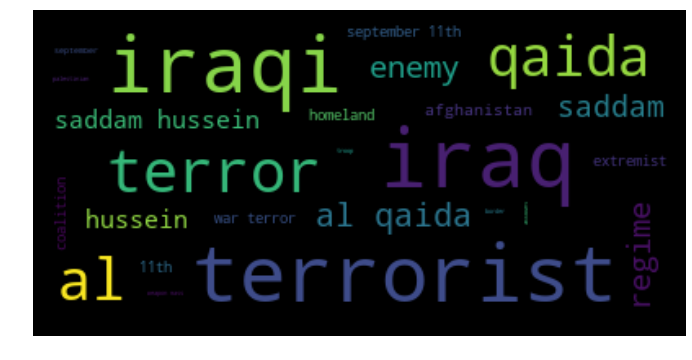

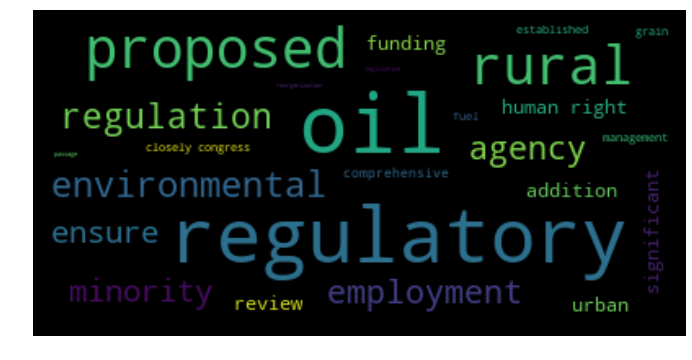

In [15]:
plot_wordcloud(nmf.components_,tfidf_feature_names,25)

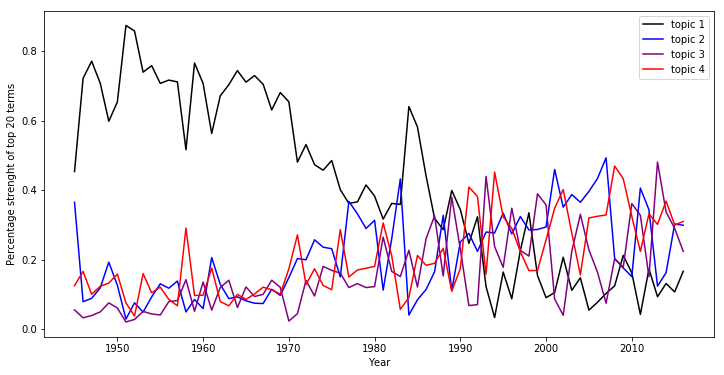

In [16]:
plotTraces(nmf, tfidf, 20);

![alt text](https://cdn-images-1.medium.com/max/1600/1*MLJVWz4EdOFsqhvBxEi9iA.png "Topic Analysis")
